# UrbanPy model for Florianópolis
Start date: 2022-12-30

Make sure the necessary packages are installed from the `pipenv` file created for this work.

To do this, go to the local directory for this project, and in your terminal run:

`pipenv install`

Then, activate the environment by running 

`pipenv shell`

**Note**: @robcrystalornelas needed to run `brew install gdal` in terminal and then `pip install urbanpy` in this notebook to get code below to run. Issue submitted about installation difficulties [here](https://github.com/EL-BID/urbanpy/issues/18).

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)


import sys
sys.path.append('..')

import urbanpy as up
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
import plotly.express as px 
import osmnx as ox

## Download urban data

We'll begin by downloading data for Florianópolis, Brazil.  Specify the place we'll analyze by name (this is just for displaying on the map we print out below), and then the function ending in _osm gives us the city limits. 

In [2]:
city = 'Florianópolis, Brazil'
flor = up.download.nominatim_osm(city)

Plot the data we downloaded for Florianopolis

Text(0.5, 1.0, 'Florianópolis, Brazil')

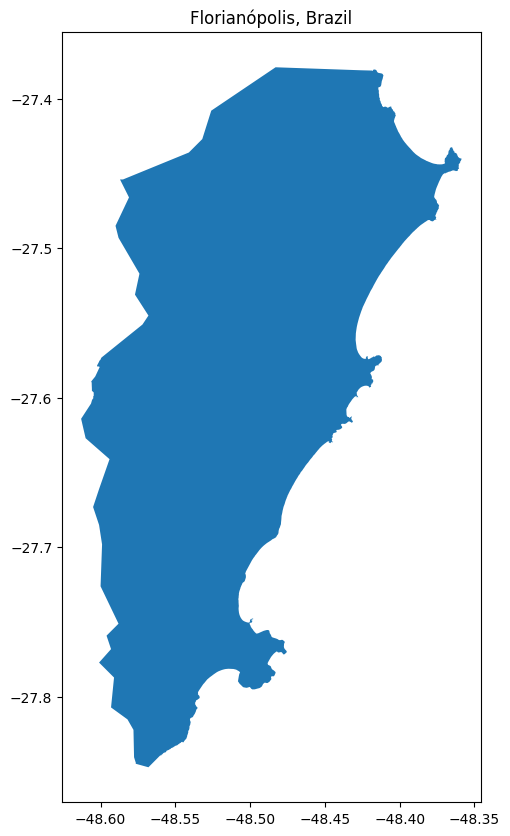

In [3]:
flor.plot()
plt.title(city)

## Divide city into hexagons for spatial analysis

In the function below, the city argument requires a spatial object (for us Florianopolis).
`resolution` argument can be adjusted depending on how many hexagons we want in our grid. 

_Higher numbers means greater resolution and a greater number of cells._

In [4]:
h3_resolution = 8

hex_flor = up.geom.gen_hexagons(h3_resolution, city=flor)

Visualize the city with our hexagons

Text(0.5, 1.0, 'Florianópolis, Brazil. Cells H3 with resolution 8')

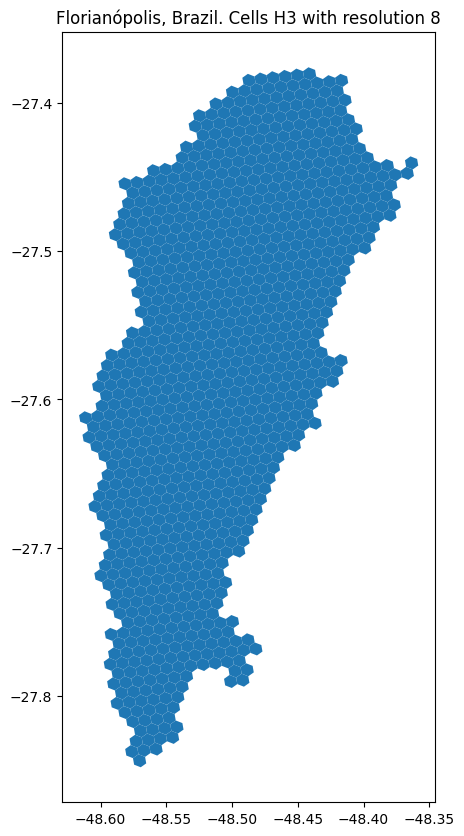

In [5]:
hex_flor.plot()
plt.title(city + ". Cells H3 with resolution " + str(h3_resolution))

Inspect the first few rows of data


In [6]:
hex_flor.head()

,hex,geometry
0,88a91b4cbbfffff,"POLYGON ((-48.45406 -27.43349, -48.44989 -27.4..."
1,88a91b540dfffff,"POLYGON ((-48.55535 -27.70570, -48.55118 -27.7..."
2,88a91bcd8dfffff,"POLYGON ((-48.53709 -27.79798, -48.53291 -27.7..."
3,88a91b5447fffff,"POLYGON ((-48.55866 -27.71273, -48.55448 -27.7..."
4,88a834b607fffff,"POLYGON ((-48.41909 -27.39639, -48.41491 -27.3..."


And see how many rows we have in the dataset. The number of rows (first number below) tells us how many cells florianopolis was divided into

In [7]:
hex_flor.shape

(977, 2)

## Download population data

You can see the data/metadata in HDX UI [here](https://data.humdata.org/dataset/brazil-high-resolution-population-density-maps-demographic-estimates).

We get the population data at the *country* level from a function in `urbanpy`.  First, list the country, then the type of population:

- `full`: entire population **this argument does not work, needs to be hard coded**
- `children`: children (age 0-5)
- `youth`: youth (15-24)
- `elderly`: Ages 60+

So let's start by getting Brazil population data.  As discussed in this [issue](https://github.com/EL-BID/urbanpy/issues/19), the population data gets moved sometimes so we need to hard code links to the full demographic data.

But if you want segments of the population for all of Brazil, that can be done through built in functions.

Look for brazil's population data here: https://data.humdata.org/dataset/brazil-high-resolution-population-density-maps-demographic-estimates

In [8]:
# pop_brazil = up.download.hdx_fb_population('brazil', 'youth')

The code below takes about 45 seconds to run.

In [9]:
full_pop_brazil_southeast = up.download.hdx_dataset(resource="c17003d1-47f4-4ec5-8229-2f77aeb114be/resource/eb17516f-3c84-4626-95e4-df1f342f3d82/download/population_bra_southeast_2018-10-01.csv.zip")

Take a look at the population data. For Brazil, all these data are from 2019

In [10]:
full_pop_brazil_southeast.head()

,latitude,longitude,population_2015,population_2020
0,-31.311806,-50.980972,1.023954,0.996145
1,-31.278194,-50.942361,1.279943,1.245182
2,-31.277917,-50.942361,1.279943,1.245182
3,-31.277917,-50.942083,1.279943,1.245182
4,-31.277917,-50.941806,1.279943,1.245182


Next, filter for the area of interest. The `filter_population` function works by a bounding box, so not an exact shape of the city of interest


In [11]:
pop_flor = up.geom.filter_population(full_pop_brazil_southeast, flor)

Now visualize the population data. We'll see that the data go beyond the city limits

<AxesSubplot: >

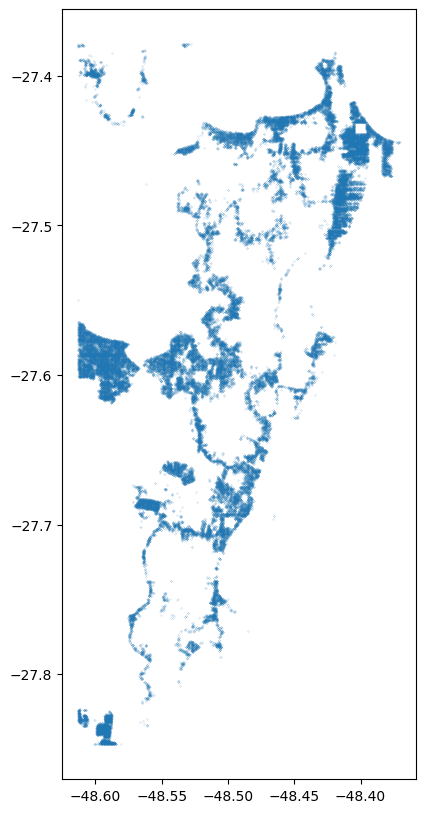

In [12]:
pop_flor.plot(markersize=0.01)

Then, calculate the population per hexagon. 

**Note** be sure to change the field `population_2020` to match the population column in your dataset. There are sometimes multiple population columns downloaded for different census times.

In [13]:
pop_flor.head()

,latitude,longitude,population_2015,population_2020,geometry
889185,-27.846806,-48.600694,0.533490,0.599087,POINT (-48.60069 -27.84681)
889186,-27.846806,-48.600417,0.533490,0.599087,POINT (-48.60042 -27.84681)
889187,-27.846806,-48.600139,0.533490,0.599087,POINT (-48.60014 -27.84681)
889188,-27.846806,-48.599306,0.473721,0.531969,POINT (-48.59931 -27.84681)
889189,-27.846806,-48.597083,0.473721,0.531969,POINT (-48.59708 -27.84681)


In [14]:
hex_flor.head()

,hex,geometry
0,88a91b4cbbfffff,"POLYGON ((-48.45406 -27.43349, -48.44989 -27.4..."
1,88a91b540dfffff,"POLYGON ((-48.55535 -27.70570, -48.55118 -27.7..."
2,88a91bcd8dfffff,"POLYGON ((-48.53709 -27.79798, -48.53291 -27.7..."
3,88a91b5447fffff,"POLYGON ((-48.55866 -27.71273, -48.55448 -27.7..."
4,88a834b607fffff,"POLYGON ((-48.41909 -27.39639, -48.41491 -27.3..."


In [15]:
hex_flor = up.geom.merge_shape_hex(
    hexs = hex_flor, 
    shape = pop_flor, 
    agg={'population_2020': 'sum'}
)

In [16]:
hex_flor.head()

,hex,geometry,population_2020
0,88a91b4cbbfffff,"POLYGON ((-48.45406 -27.43349, -48.44989 -27.4...",1718.296972
1,88a91b540dfffff,"POLYGON ((-48.55535 -27.70570, -48.55118 -27.7...",334.904771
2,88a91bcd8dfffff,"POLYGON ((-48.53709 -27.79798, -48.53291 -27.7...",130.529135
3,88a91b5447fffff,"POLYGON ((-48.55866 -27.71273, -48.55448 -27.7...",448.841956
4,88a834b607fffff,"POLYGON ((-48.41909 -27.39639, -48.41491 -27.3...",405.651868


## Visualize data on static map

And then look at these data on a map

Text(0.5, 1.0, 'Florianópolis, Brazil. Population 2020')

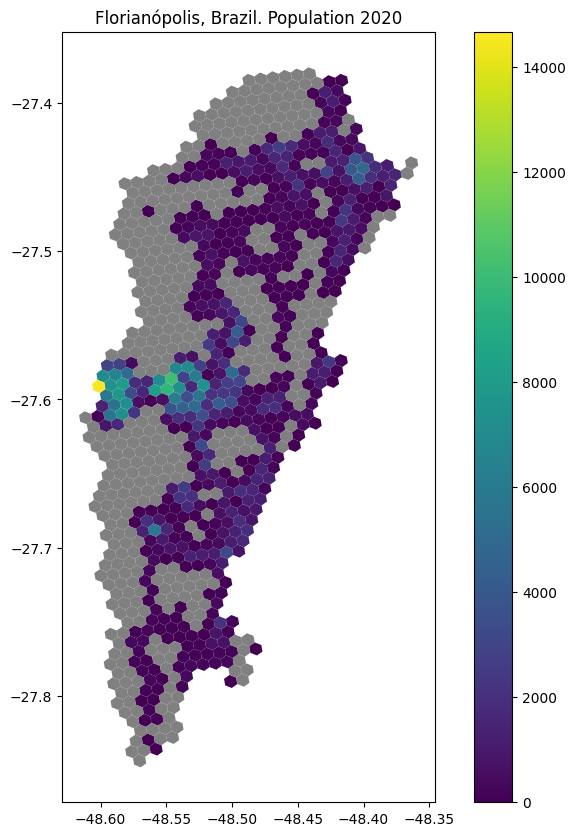

In [17]:
hex_flor.plot('population_2020', legend=True, missing_kwds={'color':'grey'})
plt.title(city + ". Population 2020")

## Visualize data on interactive map

In [18]:
fig = up.plotting.choropleth_map(
    hex_flor, 
    'population_2020', 
    title=city + '. Population - 2020', 
    zoom = 10, 
    color_continuous_scale="Viridis",
    opacity=0.8,
    labels={'population':'Population 2020'}                                 
)

fig.update_layout(
    margin=dict(l=0, r=0, t=30, b=0),
)

fig.show()

## Take another slice of the population. This time focusing on children 0-5

In [19]:
pop_brazil_children = up.download.hdx_fb_population('brazil', 'children')

In [20]:
pop_brazil_children.head()

,latitude,longitude,population
0,-27.012917,-51.737361,0.330375
1,-27.010139,-51.738750,0.330375
2,-27.009583,-51.740417,0.330375
3,-27.010139,-51.741806,0.330375
4,-27.009306,-51.739028,0.330375


In [21]:
pop_brazil_children = up.geom.filter_population(pop_brazil_children, flor)

In [22]:
hex_flor_children = up.geom.merge_shape_hex(hex_flor, pop_brazil_children, agg={'population':'sum'})

Check out results

In [23]:
hex_flor_children.head()

,hex,geometry,population_2020,population
0,88a91b4cbbfffff,"POLYGON ((-48.45406 -27.43349, -48.44989 -27.4...",1718.296972,82.935727
1,88a91b540dfffff,"POLYGON ((-48.55535 -27.70570, -48.55118 -27.7...",334.904771,15.348800
2,88a91bcd8dfffff,"POLYGON ((-48.53709 -27.79798, -48.53291 -27.7...",130.529135,9.553391
3,88a91b5447fffff,"POLYGON ((-48.55866 -27.71273, -48.55448 -27.7...",448.841956,20.567392
4,88a834b607fffff,"POLYGON ((-48.41909 -27.39639, -48.41491 -27.3...",405.651868,15.710215


In [24]:
hex_flor_children = hex_flor_children.rename(columns = {'population':'pop_children_flor'})

In [25]:
hex_flor_children.head()

,hex,geometry,population_2020,pop_children_flor
0,88a91b4cbbfffff,"POLYGON ((-48.45406 -27.43349, -48.44989 -27.4...",1718.296972,82.935727
1,88a91b540dfffff,"POLYGON ((-48.55535 -27.70570, -48.55118 -27.7...",334.904771,15.348800
2,88a91bcd8dfffff,"POLYGON ((-48.53709 -27.79798, -48.53291 -27.7...",130.529135,9.553391
3,88a91b5447fffff,"POLYGON ((-48.55866 -27.71273, -48.55448 -27.7...",448.841956,20.567392
4,88a834b607fffff,"POLYGON ((-48.41909 -27.39639, -48.41491 -27.3...",405.651868,15.710215


In [26]:
fig = up.plotting.choropleth_map(hex_flor_children, 'pop_children_flor', title=city + '. Estimated population for 0-5 year olds - 2019', 
                                 zoom = 10, color_continuous_scale="Viridis",
                                 opacity=0.8,
                                 labels={'pop_children_flor':'Children age 0-5 in 2019'}
                                 
                                 )

fig.update_layout(
    margin=dict(l=0, r=0, t=30, b=0),
)

fig.show()

## Urban accessibility

First, we have to define the location of interest and get lat/long for those points of interest.
 
We will get these point of interest from the OpenStreetMap database

You need to specify a bounding box which we can get from:

In [27]:
ciudad = 'Florianópolis, Brazil'

ba = up.download.nominatim_osm(ciudad)

We are interested in evaluating accessibility to schools/education infrastructure.

In [28]:
ba.total_bounds

array([-48.613    , -27.847    , -48.3585929, -27.379    ])

In [29]:
es = up.download.overpass_pois(bounds=ba.total_bounds, facilities='education')

Keeping the code below in case overpass does not work

In [30]:
import requests

minx, miny, maxx, maxy = ba.total_bounds

bbox_string = f'{minx},{miny},{maxx},{maxy}'

overpass_url = "https://overpass-api.de/api/interpreter"

facilities_opt = {
'food': 'node["amenity"="marketplace"];\nnode["shop"~"supermarket|kiosk|mall|convenience|butcher|greengrocer"];',
'health': 'node["amenity"~"doctors|dentist|clinic|hospital|pharmacy"];',
'education': 'node["amenity"~"kindergarten|school|college|university"];',
'finance': 'node["amenity"~"mobile_money_agent|bureau_de_change|bank|microfinance|atm|sacco|money_transfer|post_office"];',
}

overpass_query = f"""
    [timeout:120][out:json][bbox];
    (
        {facilities_opt['education']}
    );
    out body geom;
    """
# Request data
response = requests.get(overpass_url, params={'data': overpass_query,
                                                'bbox': bbox_string})

In [31]:
response.json()

{'version': 0.6,
 'generator': 'Overpass API 0.7.59 e21c39fe',
 'osm3s': {'timestamp_osm_base': '2023-02-14T22:28:04Z',
  'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'},
 'elements': [{'type': 'node',
   'id': 1404551652,
   'lat': -27.6792879,
   'lon': -48.4971141,
   'tags': {'amenity': 'school',
    'name': 'Escola Engenho',
    'website': 'https://www.escolaengenho.com.br/'}},
  {'type': 'node',
   'id': 1429425790,
   'lat': -27.6742369,
   'lon': -48.5052724,
   'tags': {'amenity': 'language_school', 'name': 'Extra English'}},
  {'type': 'node',
   'id': 1440281872,
   'lat': -27.6761318,
   'lon': -48.5003806,
   'tags': {'addr:housenumber': '799',
    'addr:street': 'Avenida Pequeno Príncipe',
    'amenity': 'school',
    'name': 'Tempo de Despertar'}},
  {'type': 'node',
   'id': 1453290633,
   'lat': -27.6844541,
   'lon': -48.4893397,
   'tags': {'amenity': 'college',
    'name': 'Escola de Surf',
   

Now take a look at all the education data we just downloaded. You can see the different poi_types which show the categories of schools, colleges, etc.

In [32]:
es.head()

,type,id,lat,lon,tags,geometry,poi_type
0,node,1404551652,-27.679288,-48.497114,"{'amenity': 'school', 'name': 'Escola Engenho'...",POINT (-48.49711 -27.67929),school
1,node,1429425790,-27.674237,-48.505272,"{'amenity': 'language_school', 'name': 'Extra ...",POINT (-48.50527 -27.67424),language_school
2,node,1440281872,-27.676132,-48.500381,"{'addr:housenumber': '799', 'addr:street': 'Av...",POINT (-48.50038 -27.67613),school
3,node,1453290633,-27.684454,-48.489340,"{'amenity': 'college', 'name': 'Escola de Surf...",POINT (-48.48934 -27.68445),college
4,node,1454993590,-27.599978,-48.511266,"{'amenity': 'school', 'name': 'Colégio COC'}",POINT (-48.51127 -27.59998),school


In [33]:
es.poi_type.value_counts()

school             14
college            13
kindergarten        7
language_school     4
driving_school      3
university          2
music_school        1
Name: poi_type, dtype: int64

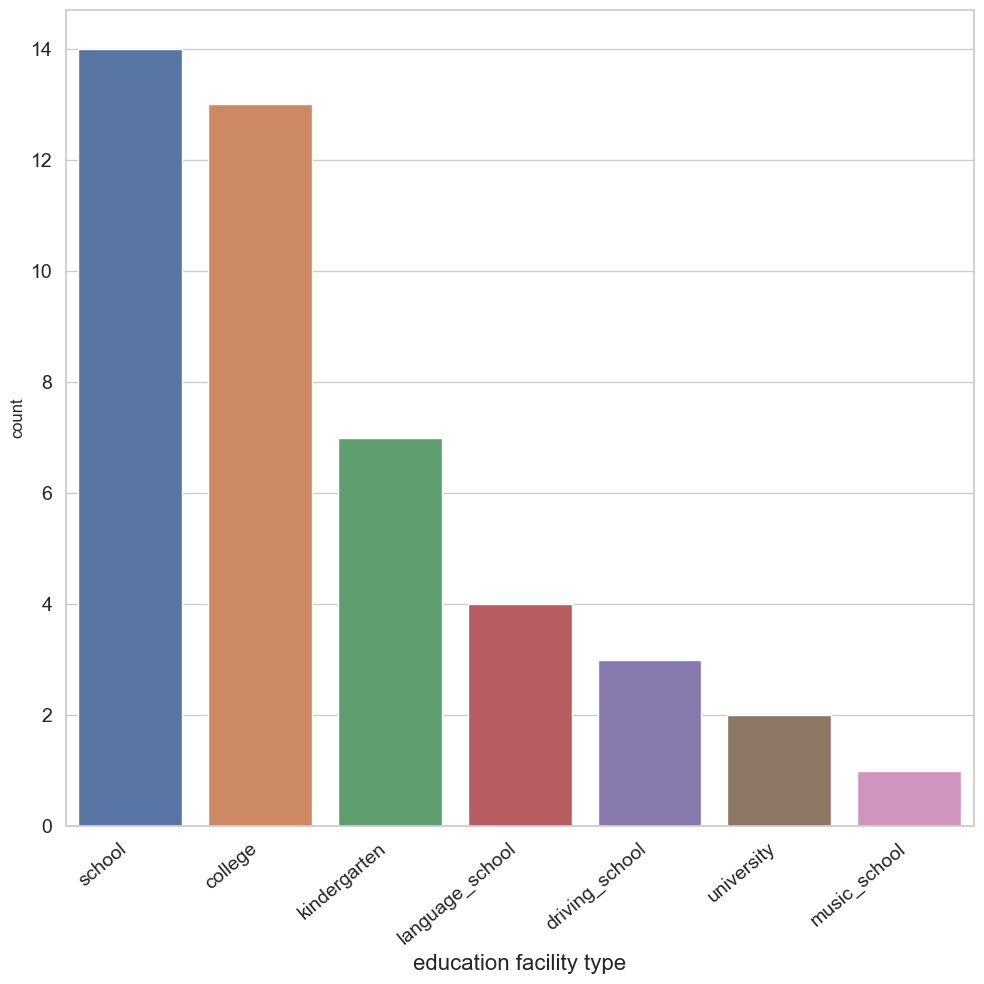

In [34]:
# create a hisogram in seaborn showing the number of schools per type
# order countplt by the number of schools per type
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.countplot(x="poi_type", data=es, order=es.poi_type.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
# increase tick label size
ax.tick_params(labelsize=14)
# increase x and y label size
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
# change x axis label to "education facility type"
ax.set_xlabel("education facility type", fontsize=16)
plt.tight_layout()
plt.show()


## Make plot of facilities in florianopolis 

Text(0.5, 1.0, 'Florianópolis, Brazil. Education facilities')

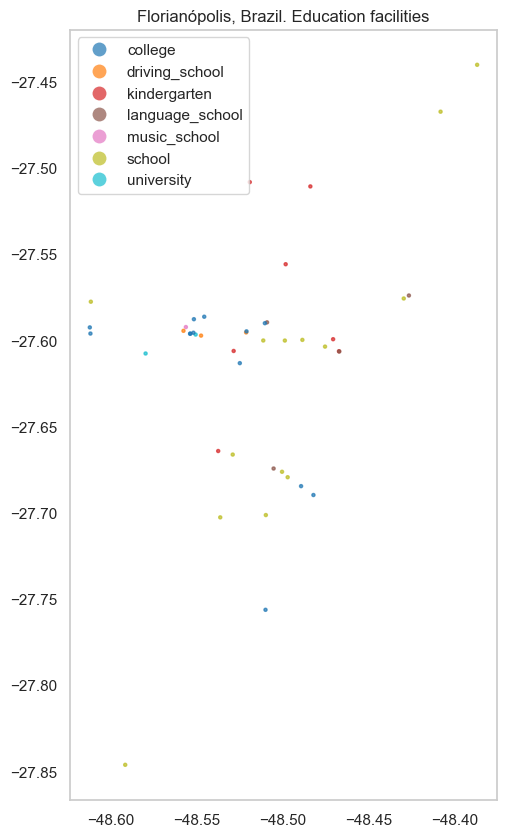

In [35]:
es.plot('poi_type', markersize = 5, alpha = 0.7, legend=True)
# mack background white with grid
plt.grid(color='white', linestyle='-', linewidth=1)
plt.title(ciudad + ". Education facilities")


## Evaluate accessibility

Here's where we can specify the type of facilities

In [36]:
# create object called schools with poi_type of school, kindergarten, language school, toy library and library
schools = es[es['poi_type'].isin(['school', 'kindergarten', 'language_school', 'library'])]

In [37]:
schools.head()

,type,id,lat,lon,tags,geometry,poi_type
0,node,1404551652,-27.679288,-48.497114,"{'amenity': 'school', 'name': 'Escola Engenho'...",POINT (-48.49711 -27.67929),school
1,node,1429425790,-27.674237,-48.505272,"{'amenity': 'language_school', 'name': 'Extra ...",POINT (-48.50527 -27.67424),language_school
2,node,1440281872,-27.676132,-48.500381,"{'addr:housenumber': '799', 'addr:street': 'Av...",POINT (-48.50038 -27.67613),school
4,node,1454993590,-27.599978,-48.511266,"{'amenity': 'school', 'name': 'Colégio COC'}",POINT (-48.51127 -27.59998),school
6,node,1681023425,-27.575607,-48.429784,"{'amenity': 'school', 'name': 'Escola Básica A...",POINT (-48.42978 -27.57561),school


Visualize just the schools

<AxesSubplot: >

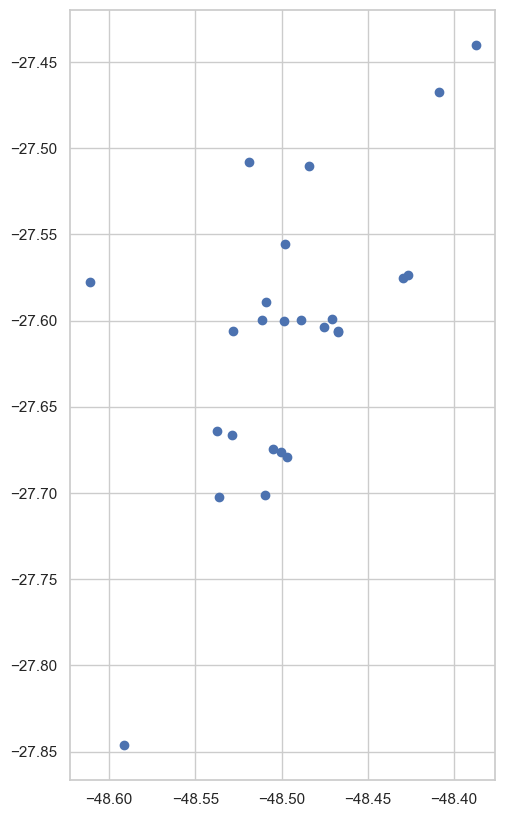

In [38]:
schools.plot()

With the location of all the schools completed, let's figure out the distance from the centroid of each hexagon in our maps created above to the eduational facilities

In [39]:
hex_flor['lat'] = hex_flor.geometry.centroid.y
hex_flor['lon'] = hex_flor.geometry.centroid.x

The nn_search function within the urbanpy library can do nearest neighbor calcualtions

In [40]:
dist_up, ind_up = up.utils.nn_search(
    tree_features=schools[['lat', 'lon']].values, # These are the schools
    query_features=hex_flor[['lat', 'lon']].values, # Values are the centroids of each hexagon
    metric='haversine'
)

Add in a new variable which will indicate the index of the closest school for that particular hexagon

In [41]:
hex_flor['closest_school'] = ind_up
hex_flor.head()

,hex,geometry,population_2020,lat,lon,closest_school
0,88a91b4cbbfffff,"POLYGON ((-48.45406 -27.43349, -48.44989 -27.4...",1718.296972,-27.429077,-48.454933,15
1,88a91b540dfffff,"POLYGON ((-48.55535 -27.70570, -48.55118 -27.7...",334.904771,-27.701298,-48.556222,10
2,88a91bcd8dfffff,"POLYGON ((-48.53709 -27.79798, -48.53291 -27.7...",130.529135,-27.793589,-48.537962,22
3,88a91b5447fffff,"POLYGON ((-48.55866 -27.71273, -48.55448 -27.7...",448.841956,-27.708328,-48.559529,10
4,88a834b607fffff,"POLYGON ((-48.41909 -27.39639, -48.41491 -27.3...",405.651868,-27.391973,-48.419960,6


## Starting up OSM server

In [48]:
up.routing.start_osrm_server('sul', 'south-america_brazil', 'foot')

[
    {
        "Id": "2ce75c74142e442dd48ae9fca40443482527d419f2424e49a3e694cdd1576e07",
        "Created": "2023-02-09T21:02:43.763604512Z",
        "Path": "osrm-routed",
        "Args": [
            "--algorithm",
            "mld",
            "/data/sul-latest.osm.pbf"
        ],
        "State": {
            "Status": "created",
            "Running": false,
            "Paused": false,
            "Restarting": false,
            "OOMKilled": false,
            "Dead": false,
            "Pid": 0,
            "ExitCode": 0,
            "Error": "",
            "StartedAt": "0001-01-01T00:00:00Z",
            "FinishedAt": "0001-01-01T00:00:00Z"
        },
        "Image": "sha256:6e654e0e06b3b580457ae3bae43474c86f10d46eeb8b1b89899e5714eff19938",
        "ResolvConfPath": "",
        "HostnamePath": "",
        "HostsPath": "",
        "LogPath": "",
        "Name": "/osrm_routing_server_south-america_brazil_sul_foot",
        "RestartCount": 0,
        "Driver": "overlay2",
 

Apply the route calculating function to our data

In [50]:
distance_duration = hex_flor.apply(
    lambda row: up.routing.osrm_route(
        origin=row.geometry.centroid, 
        destination = schools.iloc[row['closest_school']]['geometry']
    ),
    result_type='expand',
    axis=1,
)

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

### Inspect the results.  
- `0` corresponds to the distance
- `1` corresponds to the duration of the trip by foot

Our next step is to bring these data into the `hex_flor` variable

In [51]:
distance_duration.head()

NameError: name 'distance_duration' is not defined

In [ ]:
hex_flor['distance_to_school_km'] =  distance_duration["0"] / 1000 # metros a km
hex_flor['duration_to_school_min'] = distance_duration["1"] / 60 # segundos a minutos

## Create a map for travel time to nearest schools

In [ ]:
fig = up.plotting.choropleth_map(hex_flor, 'duration_to_school_min', 
                                 title=  city + '. Estimated travel times to school', 
                                 zoom = 10, color_continuous_scale="Plasma_r",
                                 opacity=0.8,
                                 labels={'duration_to_school_min':'Duration (min)'}
                                 )

fig.update_layout(
    margin=dict(l=0, r=0, t=30, b=0),
)

fig.show()